In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels


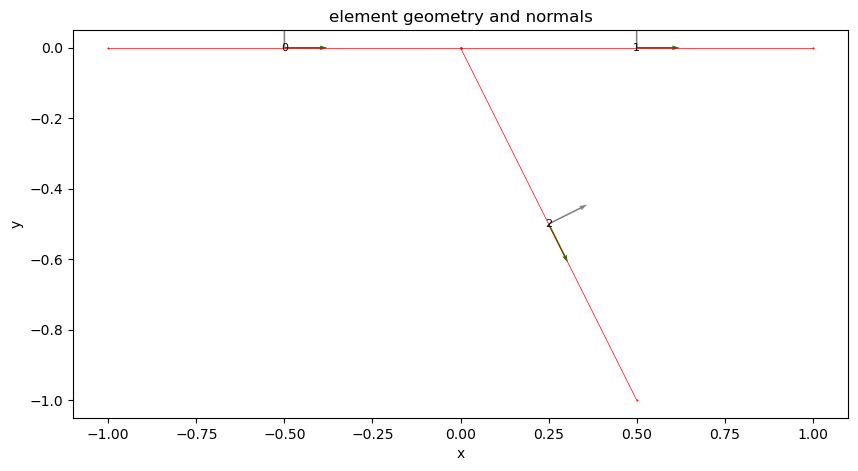

In [3]:
# Elastic parameters
mu = 1
nu = 0.25


x1 = np.array((-1.,0,0))
x2 = np.array((0.,1.,0.5))
y1 = np.array((0.,0.,0.))
y2 = np.array((0.,0.,-1.))
n_elements = len(x1)
elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())

elements = bemcs.standardize_elements(elements)

n_elements = len(elements)

plt.figure(figsize=(10,6))
bemcs.plot_element_geometry(elements)
# plt.plot(elements_midpts[:,0],elements_midpts[:,1],'o')
plt.show()